# Bachelor Thesis Source Code
By Marta Navascués Peña

Universidad Carlos III de Madrid

## Step 1: WEB SCRAPING

In [ ]:
# Import necessary libraries
from bs4.element import NavigableString
import spacy
import requests
from bs4 import BeautifulSoup
import re

# Get_article_text function
# -------
# Given an url string and a day string, extract textual information regarding headline, body, kicker and stand-first.
# Returns a dictionary object with all extracted data structured accordingly.
# -------
def get_article_text(url, day_str):
    # Send request to given url string
    res = requests.get(url, verify=False)
    # Extract content from the request
    html_page = res.content
    # Use library BeautifulSoup to parse the HTML content 
    soup = BeautifulSoup(html_page, 'html.parser')

    # Checking if the page exists by finding the error message in the title
    text = soup.find('title')
    errormessage = 'Página no encontrada o de acceso restringido'
    # If the error message is found we classify the link as not valid and return None
    if errormessage in text:
        return None

    # Finding the link to each article inside the tag for each article
    text = soup.find_all(class_ =  "content-item")
    links = []
    for tag in text[0:-1]:
        t = str(tag)
        # Locate start and end references that define the html string
        start = t.find('<a href=')
        end = t.find('.html')
        # Extract html string
        link = t[start+9:end+5]
        # Append to list of links
        links.append(link)

    output = {'day':[],
            'link':[],
            'kicker':[],
            'headline': [],
            'standfirst':[],
            'body':[]}

    # Extracting text of each article and storing not valid links
    notincluded = []
    for l in links:
        # Safety check
        # If string is not valid, skip to next one
        if len(l) == 0:
            continue
        # Request content to link
        res = requests.get(l, verify=False)
        html_page = res.content
        # Extract HTML through parser
        soup = BeautifulSoup(html_page, 'html.parser')

        # HEADLINE EXTRACTTION
        # Create empty string to store text
        x = ''
        # Find headline section through possible tag class names
        text =  soup.find(class_ =  ["ue-c-article__headline js-headline js-headlineb",
                                    'ue-c-article__headline js-headline js-headlineb ue-c-article__headline--opinion',
                                     'entry-hero'])
        # If there is not a match, it is not considered a news article, so we add it to non valid links and move 
        # to the next one
        if text is None:
            notincluded.append(l)
            continue
        # If there is a match, append text to empty string and store correspondly
        for tag in text:
            x += str(tag)
        output['headline'] += [x]

        # STANDFIRST EXTRACTION
        # Find standfirst section through class name
        text =  soup.find(class_ =  "ue-c-article__standfirst")
        # Empty string to store text
        x = ''
        # If there exists a stand-first
        if text:
            # Add textual information to empty string
            for tag in text:
                x += str(tag)
            # Add to output dictionary
            output['standfirst'] += [x]
        # If there is no stand-first we label it
        else:
            # Add to output dictionary
            output['standfirst'] += ['no standfirst']

        # BODY EXTRACTION
        # If there exists a body section with the tag below
        if soup.find(class_ =  "ue-c-article__body"):
            # Extract information from section
            text = soup.find(class_ =  "ue-c-article__body")
            # Create empty string
            x = ''
            # For each piece of text check type of data and extract text accordingly
            for tag in text:
                if type(tag) is NavigableString:
                    x += tag
                else:
                    x += tag.get_text()
        # If the above tag does not exist, it corresponds to the other tag name
        else:
            # Extract information from section
            text = soup.find(class_ =  "entry-content")
            # Create empty string
            x = ''
            # For each piece of text extract piece of text from HTML text tags
            for tag in text:
                if '<p>' in str(tag):
                    x += tag.get_text()

        # Add to output dictionary
        output['body'] += [x]

        # KICKER EXTRACTION
        # Create safety check to make sure we always add a value to the output dictionary
        is_kicker = False
        # If not found with first tag, it corresponds to second tag
        if soup.find(class_ =  ['ue-c-article__kicker-seo']) is None:
            # Extract information from section
            text = soup.find(class_ =  ['ue-c-article__kicker'])
            # If there is no text, no kicker
            if text is None:
                output['kicker'] += ['no kicker']
                is_kicker = True
            # If there is a kicker, we extract its text
            else:
                for tag in text:
                    output['kicker'] += [str(tag)]
                    is_kicker = True
        # Find information in first tag
        else:
            # Extract information from section
            text = soup.find(class_ =  ['ue-c-article__kicker-seo'])
            # If there is no text, no kicker
            if text is None:
                output['kicker'] += ['no kicker']
                is_kicker=True
                # If there is a kicker, we extract its text
            else:
                for tag in text:
                    output['kicker'] += [str(tag)]
                    is_kicker=True
        # If not kicker found in both tags, no kicker label
        if not is_kicker:
            output['kicker'] += ['no kicker']

        # Add to output dictionary the link and string of the corresponding day
        output['link'] += [l]
        output['day'] += [day_str]
    
    # Return output dictionary
    return output

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Create dictionary with all year days
year2022 = {'01':list(np.arange(17,32)),
            '02':list(np.arange(1,29)),
            '03':list(np.arange(1,32)),
            '04':list(np.arange(1,31)),
            '05':list(np.arange(1,32)),
            '06':list(np.arange(1,31)),
            '07':list(np.arange(1,32)),
            '08':list(np.arange(1,32)),
            '09':list(np.arange(1,31)),
            '10':list(np.arange(1,32)),
            '11':list(np.arange(1,12))}

year2022 = {'10':list(np.arange(2,32)),
            '11':list(np.arange(1,31)),
            '12':list(np.arange(1,31))}

# Create empty pandas dataframe with corresponding column names for each section
df2022 = pd.DataFrame(columns = ['day','link','kicker','headline','standfirst','body'])

# For each month of the year
for month in year2022.keys():
    # For each day of the month
    for day in year2022[month]:
        # Create day string
        d = str(day)
        # If it is a 1 digit day number we append a 0 before
        if len(d) == 1:
            d = '0' + d
        # For each possible tab of news articles
        for n in range(1,7):
            # For the first tab, the link only ends with 'noticias.html'
            if n == 1:
                url = 'https://www.marca.com/hemeroteca/2022/' + str(month) + '/' + str(d) + '/noticias.html'
            # For the next tabs, the link ends with 'noticias' plus the tab number
            else:
                url = 'https://www.marca.com/hemeroteca/2022/' + str(month) + '/' +str(d) + '/noticias'+ str(n) + '.html'
            # Construct full day string
            day_str = '2022/' + str(month) + '/' + str(d)
            # Call text scraping function
            news = get_article_text(url, day_str)
            # If link is not valid, move to the next one
            if news is None:
                continue
            # If link is valid
            else:
                # Create dataframe from output dictionary and append to total dataframe
                df = pd.DataFrame.from_dict(news)
                df2022 = pd.concat([df2022, df])
        print(day_str)


EDIT ONLY IF YOU WANT TO CHANGE THE LOCATION WHERE THE FILE IS STORED

In [ ]:
# Check number of articles extracted
print(len(df2022))

# Export dataframe to excel file in Google Drive
from google.colab import drive
drive.mount('drive')
df2022.to_excel('news_articles_4.xlsx')
!cp news_articles_4.xlsx "drive/My Drive/TFG"

## Step 2: Preprocessing pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Read files from drive
import pandas as pd
#df1 = pd.read_excel('/content/drive/My Drive/TFG/news_articles_1.xlsx')
df1 = pd.read_excel('news_articles_1.xlsx')
#df2 = pd.read_excel('/content/drive/My Drive/TFG/news_articles_2.xlsx')
df2 = pd.read_excel('news_articles_2.xlsx')
#df3 = pd.read_excel('/content/drive/My Drive/TFG/news_articles_3.xlsx')
df3 = pd.read_excel('news_articles_3.xlsx')
df = pd.concat([df1,df2,df3]).reset_index()

In [ ]:
# Append month column

# Import necessary library
import datetime

# Create empty list
months = []
# For each article
for index, row in df.iterrows():
    # Convert string to datetime object
    datee = datetime.datetime.strptime(row['day'], "%Y/%m/%d")
    # Extract month value
    s = str(datee.month)+'-'+str(datee.strftime('%B'))
    months.append(datee.month)

# Append column to dataframe
df['month'] = months

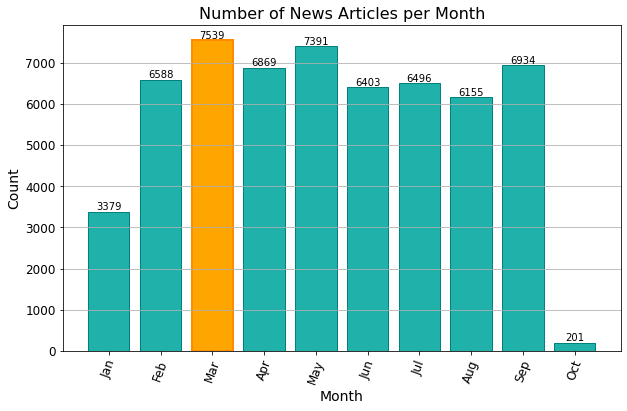

In [ ]:
# Imports
import matplotlib.pyplot as plt

# Months list
m = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']

# Plot the number of articles per month
df_gb = df.groupby(['month']).size().sort_index().to_frame().reset_index()
df_gb['monthN'] = m
df_gb = df_gb.rename(columns={0: "count"})

# Find the index of the month with the max value
max_idx = df_gb['count'].idxmax()

# Draw a vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_gb['monthN'], df_gb['count'], color=['lightseagreen'] * 10, 
        edgecolor=['teal'] * 10, linewidth=[1] * 10)
plt.bar(max_idx, df_gb.loc[max_idx, 'count'], color='orange', edgecolor='darkorange', linewidth=2)

# Add text labels to each bar
for i in range(len(df_gb)):
    plt.text(i, df_gb.loc[i, 'count'], df_gb.loc[i, 'count'], ha='center', va='bottom')

# Add titles, axis labels, and gridlines
plt.title('Number of News Articles per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12, rotation=70)
plt.yticks(fontsize=12)
plt.grid(axis='y')

plt.show()

In [ ]:
# Import the necessary libraries
import pandas as pd

# Create auxiliary dataframe with count of articles per day
aux_df = df.groupby(['day']).size().to_frame().reset_index().rename(columns={0: 'count'})

# Create a list to store the day of the week for each row
day_week = []

# List of possible weekdays
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Iterate over the rows of the auxiliary dataframe
for index, row in aux_df.iterrows():
    # Calculate the index for the corresponding weekday
    i = index % len(days)
    # Append the weekday to the list
    day_week.append(days[i])

# Append the 'weekday' column to the auxiliary dataframe
aux_df['weekday'] = day_week

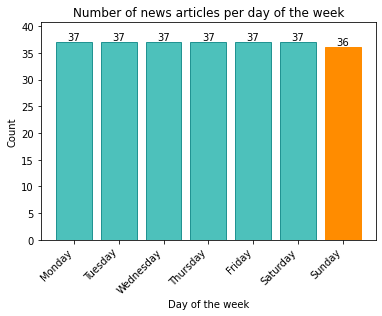

In [ ]:
import matplotlib.pyplot as plt

# Plot the average number of rows per day of the week
df_gb = aux_df.groupby('weekday')['count'].mean().reindex(d)

# Highlight the minimum value
min_value = df_gb.min()

plt.bar(x=d, height=df_gb, color='lightseagreen', edgecolor='teal', linewidth=1, alpha=0.8)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Day of the week')
plt.ylabel('Average number of articles')
plt.title('Average Number of Articles per Day of the Week')
plt.ylim([0, df_gb.max() * 1.1])

for i, v in enumerate(df_gb):
    if v == min_value:
        plt.gca().get_children()[i].set_color('darkorange')
        plt.gca().get_children()[i].set_alpha(1)
        plt.annotate(str(int(v)), xy=(i, v), ha='center', va='bottom', fontsize=10)
    else:
        plt.annotate(str(int(v)), xy=(i, v), ha='center', va='bottom', fontsize=10)

plt.show()

In [ ]:
# Step 1: Remove null values and join columns
df = df.dropna()
print(len(df))

joinedText = []
# For each article, add all text together
for index, row in df.iterrows():
    if 'kicker' in str(row['kicker']):
        k = ' '
    else:
        k = str(row['kicker'])
    if 'standfirst' in str(row['standfirst']):
        s = ' '
    else:
        s = str(row['standfirst'])
    l = [k,str(row['headline']),s,str(row['body'])]
    joinedText.append('  '.join(l))

# Append column to dataframe
df['joinedText'] = joinedText

57932


/var/folders/cr/y_rrgmnj7h199fkhvxmytqqc0000gn/T/ipykernel_5917/3398325603.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['joinedText'] = joinedText


In [ ]:
# Step 2: Convert to lowercase
df['joinedText'] = df['joinedText'].str.lower()

/var/folders/cr/y_rrgmnj7h199fkhvxmytqqc0000gn/T/ipykernel_5917/1506474852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['joinedText'] = df['joinedText'].str.lower()


In [ ]:
# Step 3: Remove specific html elements
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44

def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', text)

for index, row in df.iterrows():
    row['joinedText'] = remove_html_tags(row['joinedText'])

In [ ]:
# Step 4: Remove numbers and special characters
# https://matiasbattocchia.github.io/datitos/Preprocesamiento-de-texto-para-NLP-parte-1.html#Expresiones-regulares

import string
import re

df['joinedText'] = df['joinedText'].str.replace(r'\d+',' ')
df['joinedText'] = df['joinedText'].replace(r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']', ' ', regex=True)
def normalize(texto):
    # todo a minúsculas
    # texto = texto.lower()

    # tildes y diacríticas
    texto = re.sub('á', 'a', texto)
    texto = re.sub('é', 'e', texto)
    texto = re.sub('í', 'i', texto)
    texto = re.sub('ó', 'o', texto)
    texto = re.sub('ú', 'u', texto)
    texto = re.sub('ü', 'u', texto)
    texto = re.sub('ñ', 'n', texto)
    texto = re.sub('Á', 'A', texto)
    texto = re.sub('É', 'E', texto)
    texto = re.sub('Í', 'I', texto)
    texto = re.sub('Ó', 'O', texto)
    texto = re.sub('Ú', 'U', texto)
    texto = re.sub('Ü', 'U', texto)
    texto = re.sub('Ñ', 'N', texto)

    return texto
 
df['joinedText'] = df['joinedText'].apply(lambda x: normalize(x))

texts = df.joinedText.tolist()

/var/folders/cr/y_rrgmnj7h199fkhvxmytqqc0000gn/T/ipykernel_2993/1847875456.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['joinedText'] = df['joinedText'].str.replace(r'\d+',' ')


In [ ]:
# Spacy model
! python -m spacy download es_core_news_md

In [ ]:
# Step 5: tokenization, remove stopwords and lemmatize

# Import necessary library
import spacy

# Create empty list for collection vocabulary
tokenized_text = []
# Load spacy spanish model
#nlp = spacy.load("es_core_news_md")
# List of non relevant words
blackList = ['kwidgetiframecontainer','kalturaplayer','function','typeof','kalturaue','tags','setsection',
            'kalturaplayerconfig','split','object','jquery','load','setconfig','settags','settopic','height',
            'important','kwidgetiframecontainer','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
            'p','q','r','s','t','u','v','w','x','y','z']
# Start article counter
counter = 0
for article in texts:
    # Print amount of articles processed
    if counter%10000 == 0:
        print(counter, ' texts tokenized')
    # Create nlp document from each article
    doc = nlp(article)
    # Create empty list for article vocabulary
    tokenized_article = []
    # Add Named Entities
    for i in doc.ents:
        if i.label_ == 'ORG' or i.label_ == 'LOC' or i.label_ == 'PER':
            s = i.text.split()
            tokenized_article.append('-'.join(s).lower())
    # For each token in the article
    for i in range(0,len(doc)):
        token = doc[i]
        # Exclude stop words, white spaces and '\n' symbol
        if not token.is_stop and ' ' not in str(token) and '\n' not in str(token) and str(token.text) not in blackList:
            tokenized_article.append(token.text.lower())
    tokenized_text.append(tokenized_article)
    counter += 1

df['tokenized_data'] = tokenized_text

In [ ]:
# Saving the tokenized data
import pickle
with open("pipe7-vocab", "wb") as fp:   #Pickling
    pickle.dump(tokenized_text, fp)

# Save the DataFrame to Excel
df.to_excel("preprocessed_data.xlsx", index=False)

In [ ]:
# Loading the tokenized data
import pickle
with open("pipe7-vocab", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Fit the vectorizer
sentences = [' '.join(words) for words in b]
vectorizer.fit(sentences)
# Save model to a file
with open("tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(vectorizer, file)

In [ ]:
# Average number of words per article
counts = []
for i in b:
    counts.append(len(i))

print(sum(counts)/(len(counts)))

199.21110957674514


In [ ]:
# Top 10 most common lemmas 

dictionary = {}
for article in b:
    for lemma in article:
        if lemma not in dictionary.keys():
            dictionary[lemma] = 1
        else:
            dictionary[lemma] += 1

dict_sorted = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

first10pairs = {k: dict_sorted[k] for k in list(dict_sorted)[180:200]}
print(first10pairs)
print('position of word jugador in frequency list: ', list(dict_sorted.keys()).index("jugador"))
print('count of word jugador: ', dict_sorted['jugador'])
print('position of word jugadora in frequency list: ', list(dict_sorted.keys()).index("jugadora"))
print('count of word jugadora: ', dict_sorted['jugadora'])
print('position of word jugadoras in frequency list: ', list(dict_sorted.keys()).index("jugadoras"))
print('count of word jugadoras: ', dict_sorted['jugadoras'])
print('position of word jugadores in frequency list: ', list(dict_sorted.keys()).index("jugadores"))
print('count of word jugadores: ', dict_sorted['jugadores'])


{'the': 6185, 'premio': 6179, 'ocasiones': 6176, 'decision': 6173, 'unico': 6152, 'pasar': 6138, 'jueves': 6106, 'lunes': 6102, 'queda': 6097, 'clubes': 6085, 'joven': 6033, 'campeonato': 6014, 'min': 6006, 'directo': 5998, 'espera': 5989, 'julio': 5977, 'cerca': 5962, 'tercer': 5957, 'iba': 5951, 'san': 5922}
position of word jugador in frequency list:  10
count of word jugador:  24492
position of word jugadora in frequency list:  1468
count of word jugadora:  1409
position of word jugadoras in frequency list:  1209
count of word jugadoras:  1695
position of word jugadores in frequency list:  12
count of word jugadores:  23536


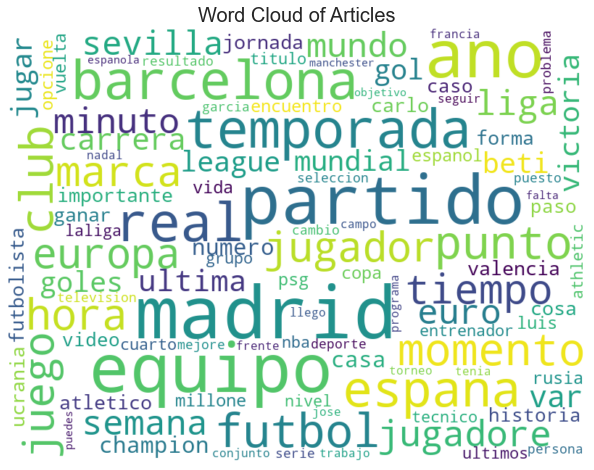

In [ ]:
# Import required libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Concatenate all the articles into a single string
article = []
for i in b:
    article.append(' '.join(i))
all_articles = ' '.join(article)

# Define the wordcloud parameters
word_cloud = WordCloud(
        width=800,                          # Width of the output image
        height=600,                         # Height of the output image
        max_font_size=100,                  # Maximum font size for the words
        max_words=100,                      # Maximum number of words to include
        background_color="white",           # Background color of the wordcloud image
        colormap="viridis",                 # Color map to be used for the words
        collocations=False,                 # Disable bigrams and trigrams
        stopwords=STOPWORDS,                # Stopwords to be excluded
        ).generate(all_articles)

# Plot the wordcloud image
plt.figure(figsize=(12,8))                  # Set the size of the plot
plt.imshow(word_cloud, interpolation='bilinear')  # Show the wordcloud image with interpolation
plt.axis("off")                             # Remove the axis labels and ticks
plt.title("Word Cloud of Articles", fontsize=20)  # Add a title to the plot
plt.show()                                  # Show the plot

In [ ]:
# Word2vec model
import gensim
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=1)

w2v_model.build_vocab(b, progress_per=10000)


In [ ]:
from time import time
t = time()

w2v_model.train(b, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 6.14 mins


In [ ]:
# save model
w2v_model.save("sportword2vec.model")

In [ ]:
h = list(w2v_model.wv.most_similar(positive=['hombre', 'entrenador'], negative=['mujer'], topn=15))
m = list(w2v_model.wv.most_similar(positive=['mujer', 'entrenadora'], negative=['hombre'], topn=15))
counter = 1
for i, j in zip(h,m):
    print(counter,'. Hombre: ', i[0],' [',str(round(i[1],2)),'] ---- Mujer: ', j[0],' [',str(round(j[1],2)),']')
    counter += 1
    
# masculino/feminino
# hombre/mujer
# hombre/mujer/tecnico
# hombre/mujer/entrenador
# hombre/mujer/fidelidad

1 . Hombre:  tecnico  [ 0.73 ] ---- Mujer:  seleccionadora  [ 0.66 ]
2 . Hombre:  jugador  [ 0.69 ] ---- Mujer:  nadadora  [ 0.61 ]
3 . Hombre:  equipo  [ 0.66 ] ---- Mujer:  eteri  [ 0.6 ]
4 . Hombre:  mister  [ 0.61 ] ---- Mujer:  burtasova  [ 0.59 ]
5 . Hombre:  portero  [ 0.61 ] ---- Mujer:  bulleux  [ 0.58 ]
6 . Hombre:  centrocampista  [ 0.59 ] ---- Mujer:  szabanin  [ 0.57 ]
7 . Hombre:  mediocentro  [ 0.59 ] ---- Mujer:  extremena  [ 0.56 ]
8 . Hombre:  preparador  [ 0.57 ] ---- Mujer:  eurocopasarina  [ 0.56 ]
9 . Hombre:  banquillo  [ 0.54 ] ---- Mujer:  nicholls  [ 0.56 ]
10 . Hombre:  futbolista  [ 0.53 ] ---- Mujer:  ngata  [ 0.56 ]
11 . Hombre:  capitan  [ 0.53 ] ---- Mujer:  capitana  [ 0.56 ]
12 . Hombre:  bielsa  [ 0.52 ] ---- Mujer:  fundadora  [ 0.56 ]
13 . Hombre:  marcelino  [ 0.52 ] ---- Mujer:  jugadora  [ 0.55 ]
14 . Hombre:  delantero  [ 0.5 ] ---- Mujer:  exjugadora  [ 0.55 ]
15 . Hombre:  bloque  [ 0.5 ] ---- Mujer:  ksenia  [ 0.55 ]


Test: NER training

In [ ]:
# Load pre-existing spacy model
import spacy
nlp=spacy.load('es_core_news_md')

# Getting the pipeline component
ner=nlp.get_pipe("ner")

In [ ]:
# training data
TRAIN_DATA = [
            ("Rafa Nadal es el mejor tenista del mundo.", {"entities": [(0, 10, "PER")]}),
            ("Courtois y Benzema tapan los problemas del Madrid.", {"entities": [(0, 8, "PER"),
                                                                                   (11, 18, "PER"),
                                                                                  (43, 49, "ORG")]}),
            ("Paula Badosa sigue invicta este año y pasa a semifinales del WTA 500 de Adelaida", {"entities": [(0, 12, "PER"),
                                                                                                              (61, 86, "ORG")]}),
            ("El lateral, un problema central para Ancelotti", {"entities": [(37, 46, "PER")]}),
            ("Betis - Barcelona: Pellegrini y Xavi se citan con la Historia", {"entities": [(0, 5, "ORG"),
                                                                                            (8, 17, "ORG"),
                                                                                            (19, 29, "PER"),
                                                                                            (32, 36, "PER")]}),
            ("Carolina Marín, a cuartos de final del Abierto de Malasia", {"entities": [(0, 14, "PER"),
                                                                                   (39, 59, "ORG")]}),
            ("Lorenzo Brown, en la élite de la Euroliga: España tiene un filón", {"entities": [(0, 13, "PER"),
                                                                                               (33, 41, "ORG"),
                                                                                               (43, 49, "LOC")]}),
            ("Anabel Medina renueva como capitana del equipo español", {"entities": [(0, 13, "PER")]}),
            ("Loïs Openda, el 'regalo de Dios' que pasó un año en el hospital y destrozó al PSG", {"entities": [(0, 11, "PER"),
                                                                                                                (27, 31, "PER"),
                                                                                                                (78, 85, "ORG")]}),
            ("Así es el cuadro de Nadal y Djokovic en el Open de Australia 2023: posibles cruces y enfrentamientos", {"entities": [(20, 25, "PER"),
                                                                                                                                    (28, 36, "PER"),
                                                                                                                                    (43, 60, "ORG")]}),
            ("El madridista Antonio Blanco 'rompe' con el Cádiz y refuerza al Alavés", {"entities": [(14, 28, "PER"),
                                                                                                    (44, 49, "ORG"),
                                                                                                    (64, 77, "ORG")]}),
            ("Granada, sede de la Copa de España", {"entities": [(0, 7, "LOC"),
                                                                 (20, 36, "ORG")]}),
            ("Nadal cae ante Hurkacz en su último partido de entrenamiento", {"entities": [(0, 5, "PER"),
                                                                                            (15, 22, "PER")]}),
            ("Alberto Toril cumple 50 partidos al frente del Real Madrid", {"entities": [(0, 13, "PER"),
                                                                                        (47, 60, "ORG")]}),
            ("Curry y los Lakers, reyes de las camisetas NBA", {"entities": [(0, 5, "PER"),
                                                                            (12, 18, "ORG"),
                                                                            (43, 48, "ORG")]}),
            ("Lee, Shane Lowry y Molinari se jugarán el HSBC en la última jornada", {"entities": [(0, 3, "PER"),
                                                                                                (5, 16, "PER"),
                                                                                                (19, 26, "PER"),
                                                                                                (42, 46, "ORG")]}),
            ("Roberto Bautista termina con la magia de Andy Murray en Australia", {"entities": [(0, 16, "PER"),
                                                                                                (46, 52, "PER"),
                                                                                                (56, 65, "LOC")]}),
            ("Alemania, Noruega y Egipto cierran su pase a los cuartos de final del Mundial", {"entities": [(0, 8, "LOC"),
                                                                                                            (10, 17, "LOC"),
                                                                                                            (20, 26, "LOC"),
                                                                                                            (70, 77, "ORG")]})]

In [ ]:
# Adding labels to the `ner`

for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])
        
# Disable pipeline components you dont need to change
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]


# Import requirements
import random
from spacy.util import minibatch, compounding
from pathlib import Path
from spacy.training.example import Example

# TRAINING THE MODEL
with nlp.disable_pipes(*unaffected_pipes):

  # Training for 30 iterations
  for iteration in range(30):

    # shuufling examples  before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    for batch in spacy.util.minibatch(TRAIN_DATA, size=2):
        for text, annotations in batch:
            # create Example
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            # Update the model
            nlp.update([example], losses=losses, drop=0.3)
            print("Losses", losses)

Losses {'ner': 3.8585642257680783}
Losses {'ner': 8.665804267056899}
Losses {'ner': 9.053056559329342}
Losses {'ner': 11.85224766657515}
Losses {'ner': 14.32037968174493}
Losses {'ner': 15.88643562558396}
Losses {'ner': 15.945175842914662}
Losses {'ner': 15.964759502840929}
Losses {'ner': 17.418529926171637}
Losses {'ner': 18.178491357032332}
Losses {'ner': 21.939593094445065}


/Users/martanavascues/opt/anaconda3/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "Loïs Openda, el 'regalo de Dios' que pasó un año e..." with entities "[(0, 11, 'PER'), (27, 31, 'PER'), (78, 85, 'ORG')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/martanavascues/opt/anaconda3/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "Lee, Shane Lowry y Molinari se jugarán el HSBC en ..." with entities "[(0, 3, 'PER'), (5, 16, 'PER'), (19, 26, 'PER'), (...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/martanavascues/opt/anaconda3/lib/python3.9/site-packages/spacy/train

Losses {'ner': 24.43905956950752}
Losses {'ner': 26.110016849772897}
Losses {'ner': 27.39950468078871}
Losses {'ner': 30.48795352739143}
Losses {'ner': 30.582798968779503}
Losses {'ner': 31.877084133426354}
Losses {'ner': 31.8772526249914}
Losses {'ner': 0.2506738961859026}
Losses {'ner': 1.1099372455735013}
Losses {'ner': 2.1977272924429907}
Losses {'ner': 2.2015807629951216}


/Users/martanavascues/opt/anaconda3/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "El madridista Antonio Blanco 'rompe' con el Cádiz ..." with entities "[(14, 28, 'PER'), (44, 49, 'ORG'), (64, 77, 'ORG')...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/martanavascues/opt/anaconda3/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "Paula Badosa sigue invicta este año y pasa a semif..." with entities "[(0, 12, 'PER'), (61, 86, 'ORG')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/martanavascues/opt/anaconda3/lib/python3.9/site-packages/spacy/training/iob_utils.py:

Losses {'ner': 4.188123136343009}
Losses {'ner': 4.188417869414214}
Losses {'ner': 4.191323376245224}
Losses {'ner': 5.218619896557926}
Losses {'ner': 6.734363024773347}
Losses {'ner': 7.3163486168928875}
Losses {'ner': 8.423259517449937}
Losses {'ner': 12.43497889899154}
Losses {'ner': 12.483735537189697}
Losses {'ner': 12.912792758839945}
Losses {'ner': 12.912849168150617}
Losses {'ner': 12.915638483400182}
Losses {'ner': 13.051899307302243}
Losses {'ner': 13.46953041915139}
Losses {'ner': 0.002172601161038864}
Losses {'ner': 0.9816903265105111}
Losses {'ner': 0.9843222208274377}
Losses {'ner': 0.9843239183772748}
Losses {'ner': 0.9859821149002997}
Losses {'ner': 0.9875393547696525}
Losses {'ner': 0.9875404260206978}
Losses {'ner': 1.288658298624441}
Losses {'ner': 1.3132335828568724}
Losses {'ner': 3.259112990712881}
Losses {'ner': 3.2591581771043576}
Losses {'ner': 3.260173191234421}
Losses {'ner': 3.346942805629966}
Losses {'ner': 5.337899897912893}
Losses {'ner': 5.33794828619740

Losses {'ner': 0.0015743378665962703}
Losses {'ner': 0.0016014475893228596}
Losses {'ner': 0.003603083490569662}
Losses {'ner': 0.003621476460362162}
Losses {'ner': 0.0036233735404298554}
Losses {'ner': 0.0036235845112792863}
Losses {'ner': 0.003623586617380335}
Losses {'ner': 0.003623630289599181}
Losses {'ner': 0.0036236352054926035}
Losses {'ner': 0.0036236431056663266}
Losses {'ner': 0.0036237108130294897}
Losses {'ner': 0.0036237116832290675}
Losses {'ner': 0.0036237118306924566}
Losses {'ner': 0.003623757596302471}
Losses {'ner': 4.289958800719499e-08}
Losses {'ner': 1.3532585458501355e-07}
Losses {'ner': 1.911382213193767e-06}
Losses {'ner': 0.00016168143993805048}
Losses {'ner': 0.0001621042966370448}
Losses {'ner': 0.00016210431584870412}
Losses {'ner': 0.00016248780016236524}
Losses {'ner': 0.00016249564295948624}
Losses {'ner': 0.00016343150906150274}
Losses {'ner': 0.00016343844563602758}
Losses {'ner': 0.00016344029767874463}
Losses {'ner': 0.00016361279982816533}
Losses {

Losses {'ner': 1.7767212851932455e-07}
Losses {'ner': 1.8380262646328357e-07}
Losses {'ner': 0.37283590934853195}
Losses {'ner': 0.37286542663145333}
Losses {'ner': 0.37286542664661404}
Losses {'ner': 0.37286544237674785}
Losses {'ner': 0.37286544409927713}
Losses {'ner': 0.3731991309610009}
Losses {'ner': 0.3731992357538911}
Losses {'ner': 1.1550173145014318e-07}
Losses {'ner': 0.009434112555065542}
Losses {'ner': 0.009442139238463241}
Losses {'ner': 0.009442161575135138}
Losses {'ner': 0.012677824568936513}
Losses {'ner': 0.012677826544603456}
Losses {'ner': 0.012677826552004426}
Losses {'ner': 0.012677831910477598}
Losses {'ner': 0.012677831925293538}
Losses {'ner': 0.012677948993924062}
Losses {'ner': 0.012677949481923427}
Losses {'ner': 0.012678132712927236}
Losses {'ner': 0.012696070855271104}
Losses {'ner': 0.012696070952672927}
Losses {'ner': 0.012696086536098803}
Losses {'ner': 0.012696090850098313}
Losses {'ner': 0.012696153848870033}
Losses {'ner': 0.012696153849921055}
Loss

## Step 4: DATA FOR GENDER CLASSIFIER


#### Variables

##### Gender

1 - mujer

2 - hombre

3 - neutro

4 - mixto

##### Proper name

0.- No hay nombre propio

1.- Nombre propio femenino

2.- Nombre propio masculino

3.- Nombre propio de equipo femenino

4.- Nombre propio de equipo masculino

5.- Nombre propio femenino y masculino

6.- Nombre propio de equipo femenino y de equipo masculino

In [ ]:
import spacy

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# Read data
import pandas as pd
df = pd.read_excel('2012_07_01_analisis.xlsx')

df2 = pd.read_excel('todas_2022_12_03.xlsx', sheet_name = 'Consolidado')

In [ ]:
# filter the DataFrame to keep only the rows where 'Medio desglosado' is 'Impresos' or 'Digitales'
df2 = df2[df2['Medio desglosado'].isin(['Impresos', 'Digitales'])]

In [ ]:
df = df[['Titular','Generodelosprota','nombre_propio_titular']]
df = df.rename({'Titular': 'headline', 'Generodelosprota': 'gender','nombre_propio_titular':'proper_name'}, axis='columns')
df2 = df2[['Titulodelanoticia','Géneropersonasqueaparecenenlainformación','Nombrespropiosenlostitulares']]
df2 = df2.rename({'Titulodelanoticia': 'headline', 'Géneropersonasqueaparecenenlainformación': 'gender','Nombrespropiosenlostitulares':'proper_name'}, axis='columns')

In [ ]:
print(len(df))
print(len(df2))

95439
3078


In [ ]:
l = []
for i in range(1000):
    s = 'p'+str(i)
    l.append(s)

idxs = []
for index, row in df.iterrows():
    found = False
    for i in l:
        if type(row['headline']) != str or i in row['headline'].lower():
            found = True
    if not found:
        idxs.append(index)


df1_aux = df.iloc[idxs]
df2_aux = df2.dropna()
data = pd.concat([df1_aux, df2_aux])
data



,headline,gender,proper_name
0,Vacaciones rojiblancas,2,0
1,El equipo de moda,2,0
3,Felman no puede jugar en España,2,2
4,Son unos sinverguenzas,2,0
5,España no jugará el Mundialito,2,4
...,...,...,...
7748,Corea tiene secuestrado el golf mundial,Mixto,No hay nombres
7749,"La selección, a terminar de la mejor manera",Mixto,No hay nombres
7750,“Mi madre vio algo”,Mixto,No hay nombres
7751,Javier Fernández se despide a lo grande de Rev...,Mixto,Persona Masculino


In [ ]:
data['headline'] = data['headline'].str.lower()
data.loc[data['gender'] == 'Masculino', 'gender'] = 2
data.loc[data['gender'] == 'Mixto', 'gender'] = 4
data.loc[data['gender'] == 'Femenino', 'gender'] = 1
data.loc[data['gender'] == 'Neutro', 'gender'] = 3

In [ ]:
data.loc[data['proper_name'] == 'No hay nombres', 'proper_name'] = 0
data.loc[data['proper_name'] == 'Persona Femenino', 'proper_name'] = 1
data.loc[data['proper_name'] == 'Persona Masculino', 'proper_name'] = 2
data.loc[data['proper_name'] == 'Equipo Femenino', 'proper_name'] = 3
data.loc[data['proper_name'] == 'Equipo Masculino', 'proper_name'] = 4
data.loc[data['proper_name'] == 'Persona Femenino y Masculino', 'proper_name'] = 5
data.loc[data['proper_name'] == 'Equipo Femenino y Masculino', 'proper_name'] = 6

In [ ]:
# Using only dataset 1
df_aux['gender'].value_counts()

2    46862
4     2737
1     2066
3     1414
Name: gender, dtype: int64

In [ ]:
# Using dataset 1 and 2
data['gender'].value_counts()

2    46886
4     4744
1     3093
3     1434
Name: gender, dtype: int64

In [ ]:
# Reduce number of masculine tagged data
masc = data.query('gender == 2').sample(4688)
fem = data.query('gender == 1').sample(3093)
mix = data.query('gender == 4').sample(4744)
neu = data.query('gender == 3').sample(1434)

reduced_data = pd.concat([masc, fem, mix, neu])

In [ ]:
# Import necessary library
import spacy

# Create empty list for collection vocabulary
tokenized_text = []
# Load spacy spanish model
#nlp = spacy.load("es_core_news_md")
# List of non relevant words
blackList = ['kwidgetiframecontainer','kalturaplayer','function','typeof','kalturaue','tags','setsection',
            'kalturaplayerconfig','split','object','jquery','load','setconfig','settags','settopic','height',
            'important','kwidgetiframecontainer','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
            'p','q','r','s','t','u','v','w','x','y','z']
# Start article counter
counter = 0
for article in reduced_data['headline']:
    # Print amount of articles processed
    if counter%10000 == 0:
        print(counter, ' texts tokenized')
    # Create nlp document from each article
    doc = nlp(article)
    # print(doc.ents)
    # Create empty list for article vocabulary
    tokenized_article = []
    # Add Named Entities
    for i in doc.ents:
        if i.label_ == 'ORG' or i.label_ == 'LOC' or i.label_ == 'PER':
            s = i.text.split()
            tokenized_article.append('-'.join(s).lower())
    # For each token in the article
    for i in range(0,len(doc)):
        token = doc[i]
        # Exclude stop words, white spaces and '\n' symbol
        if not token.is_stop and ' ' not in str(token) and '\n' not in str(token) and str(token.text) not in blackList:

            tokenized_article.append(token.text.lower())
    tokenized_text.append(' '.join(tokenized_article))
    counter += 1

reduced_data['tokenized_headline'] = tokenized_text

0  texts tokenized
10000  texts tokenized


In [ ]:
# save df
reduced_data.to_excel('classifier_data.xlsx')

In [ ]:
reduced_data

,headline,gender,tokenized_headline
0,vacaciones rojiblancas,2,vacaciones rojiblancas
1,el equipo de moda,2,equipo moda
3,felman no puede jugar en españa,2,felman felman jugar españa
4,son unos sinverguenzas,2,sinverguenzas
5,españa no jugará el mundialito,2,españa españa jugará mundialito
...,...,...,...
8240,feyenoord vence al atletico de madrid en el pa...,2,feyenoord atletico-de-madrid feyenoord vence a...
8241,messi da declaraciones sobre su salida del barca,2,messi messi declaraciones salida barca
8242,finalizan los juegos de tokio con la ceremonia...,3,tokio finalizan juegos tokio ceremonia clausura
8243,primeros encuentros de pretemporada para el re...,2,encuentros pretemporada real madrid atletico m...


## Step 5: Cross validation accross different classification methods

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import joblib
import scipy.sparse as sp
import pickle

df = pd.read_excel('classifier_data.xlsx')
df = df.dropna(subset=['tokenized_headline'])
df.head()

# Encode the categorical variable
le = LabelEncoder()
df['proper_name'] = le.fit_transform(df['proper_name'])

# Extract features using TF-IDF
with open("tfidf_vectorizer.pkl", "rb") as file:
    tfidf = pickle.load(file)
tfidf_features = tfidf.transform(df['tokenized_headline'])
tfidf_features = tfidf_features.toarray()

model_path = "sportword2vec.model"
w2v_model = Word2Vec.load(model_path)
sentences = [sentence.split() for sentence in df['tokenized_headline']]

embeddings = []
for sentence in sentences:
    sentence_embedding = []
    for word in sentence:
        if word in w2v_model.wv:
            sentence_embedding.append(w2v_model.wv[word])
    if sentence_embedding:
        sentence_embedding = np.mean(sentence_embedding, axis=0)
        embeddings.append(sentence_embedding)
    else:
        # Handle the case when no word in the sentence is present in the Word2Vec model's vocabulary
        embeddings.append(np.zeros(w2v_model.vector_size))
w2v_features = np.array(embeddings)


# Combine the features and the categorical variable
tfidf_sparse = sp.csr_matrix(tfidf_features)
w2v_sparse = sp.csr_matrix(w2v_features)
proper_name_sparse = sp.csr_matrix(np.array(df['proper_name']).reshape(-1, 1))

X = sp.hstack([tfidf_sparse,w2v_sparse,proper_name_sparse], format='csr')
y = df['gender']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Define the parameter grids for each model
logreg_param_grid = {'C': [0.01, 0.1, 1, 5]}
dt_param_grid = {'max_depth': [None, 5, 10]}
rf_param_grid = {'n_estimators': [100, 200, 300],
                    'max_depth': [40,50,60,None]}
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Create a list of models and their corresponding parameter grids
models = [
    (LogisticRegression(max_iter= 1000, multi_class='multinomial', solver='lbfgs'), logreg_param_grid),
    (DecisionTreeClassifier(), dt_param_grid),
    (RandomForestClassifier(), rf_param_grid),
    (SVC(), svm_param_grid)
]

best_model = None
best_score = 0.0

n_fold = 7

# Results dictionary
results_dic = {'Model':['LogReg','DT','RF','SVC'],'Accuracy':[],'F1':[],'Std Accuracy':[],'Std F1':[]}

# Perform GridSearchCV for each model
for model, param_grid in models:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_fold)
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and best score for each model
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {model.__class__.__name__}: {grid_search.best_score_}\n")

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    test_predictions = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    test_f1 = f1_score(y_test, test_predictions, average='weighted')
    print(f"Test accuracy for {model.__class__.__name__}: {test_accuracy}")
    print(f"Test F1 score for {model.__class__.__name__}: {test_f1}")

    # Compute cross-validation scores
    cv_scores_accuracy = cross_val_score(grid_search.best_estimator_, X, y, cv=n_fold)
    cv_scores_f1 = cross_val_score(grid_search.best_estimator_, X, y, cv=n_fold, scoring='f1_weighted')
    print(f"Cross-validation scores (Accuracy) for {model.__class__.__name__}: {cv_scores_accuracy}")
    print(f"Cross-validation scores (F1) for {model.__class__.__name__}: {cv_scores_f1}")
    print(f"Mean cross-validation accuracy score for {model.__class__.__name__}: {np.mean(cv_scores_accuracy)}")
    print(f"Mean cross-validation F1 score for {model.__class__.__name__}: {np.mean(cv_scores_f1)}")
    print(f"Standard deviation of cross-validation accuracy scores for {model.__class__.__name__}: {np.std(cv_scores_accuracy)}")
    print(f"Standard deviation of cross-validation F1 scores for {model.__class__.__name__}: {np.std(cv_scores_f1)}\n")
    
    # Compute and print the test confusion matrix
    confusion_mat = confusion_matrix(y_test, test_predictions)
    print(f"Test Confusion Matrix for {model.__class__.__name__}:\n{confusion_mat}\n")
    
    # Save the best model based on the best score
    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
    
    results_dic['Accuracy'].append(cv_scores_accuracy)
    results_dic['F1'].append(cv_scores_f1)
    results_dic['Std Accuracy'].append(np.std(cv_scores_accuracy))
    results_dic['Std F1'].append(np.std(cv_scores_f1))

# Save the best model to a file
if best_model is not None:
    joblib.dump(best_model, 'best_model.pkl')
    print("Best model saved successfully.")

Best parameters for LogisticRegression: {'C': 1}
Best score for LogisticRegression: 0.5982959366827861

Test accuracy for LogisticRegression: 0.607245337159254
Test F1 score for LogisticRegression: 0.6028369243731226
Cross-validation scores (Accuracy) for LogisticRegression: [0.61646586 0.61928679 0.59568056 0.60421899 0.5901557  0.59819186
 0.61878453]
Cross-validation scores (F1) for LogisticRegression: [0.61273572 0.61696382 0.59136688 0.60076851 0.58475971 0.59333327
 0.61589994]
Mean cross-validation accuracy score for LogisticRegression: 0.6061120423431545
Mean cross-validation F1 score for LogisticRegression: 0.6022611212529018
Standard deviation of cross-validation accuracy scores for LogisticRegression: 0.011155402699405015
Standard deviation of cross-validation F1 scores for LogisticRegression: 0.012064246973992485

Test Confusion Matrix for LogisticRegression:
[[294  99  14 211]
 [ 22 722  47 145]
 [ 12  46 137  92]
 [142 195  70 540]]

Best parameters for DecisionTreeClassi

In [ ]:
results_dic

{'Model': ['LogReg', 'DT', 'RF', 'SVC'],
 'Accuracy': [array([0.61646586, 0.61928679, 0.59568056, 0.60421899, 0.5901557 ,
         0.59819186, 0.61878453]),
  array([0.58534137, 0.58864892, 0.58362632, 0.5775992 , 0.60673029,
         0.60622803, 0.58061276]),
  array([0.5687751 , 0.57559016, 0.56303365, 0.55700653, 0.56855851,
         0.56253139, 0.5826218 ]),
  array([0.60190763, 0.61577097, 0.59969864, 0.59166248, 0.59568056,
         0.58965344, 0.62430939])],
 'F1': [array([0.61273572, 0.61696382, 0.59136688, 0.60076851, 0.58475971,
         0.59333327, 0.61589994]),
  array([0.5792501 , 0.57976326, 0.57224493, 0.57554241, 0.57349761,
         0.59048978, 0.55420944]),
  array([0.54446376, 0.54255258, 0.53073951, 0.52897631, 0.54807052,
         0.53650981, 0.55826421]),
  array([0.59660793, 0.61403965, 0.59554853, 0.58780739, 0.58981626,
         0.58539402, 0.62171515])],
 'Std Accuracy': [0.011155402699405015,
  0.011013585334752071,
  0.007992018615872147,
  0.011884908690601

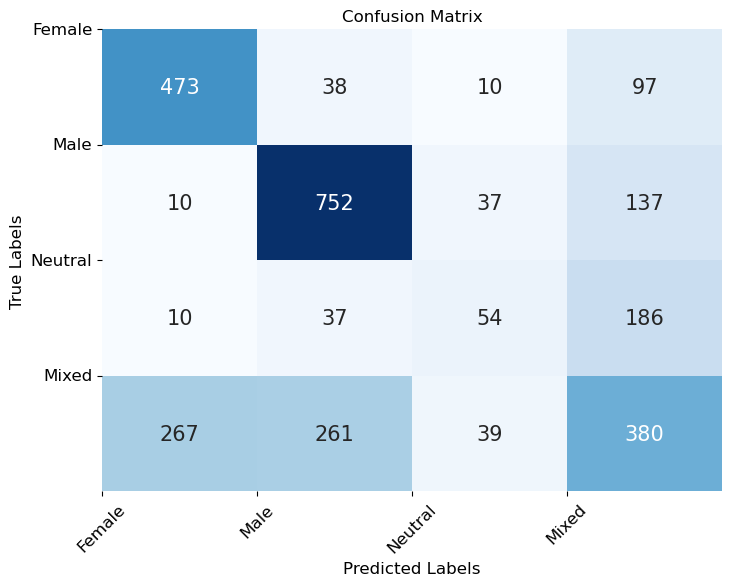

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 15})
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, fontsize=12)
    plt.yticks(ticks=range(len(labels)), labels=labels, rotation=0, fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

confusion_matrix = [[473, 38, 10,97],
                     [ 10, 752,  37, 137],
                    [ 10,  37, 54,  186],
                     [267, 261,  39, 380]]

labels = ['Female', 'Male', 'Neutral', 'Mixed']

plot_confusion_matrix(confusion_matrix, labels)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_accuracy(results_dic):
    # define data
    classifiers = list(results_dic['Model'])
    folds = range(1, 8)
    accuracies = results_dic['Accuracy']

    # create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    markers = ['o', 's', 'D', '^']
    for i in range(len(classifiers)):
        ax.plot(folds, accuracies[i], label=classifiers[i], color=colors[i], marker=markers[i])

    # add labels and legend
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Accuracy for Classifiers over 7 Folds', fontsize=14)
    ax.set_xticks(folds)
    ax.tick_params(axis='both', labelsize=10)
    ax.legend(fontsize=10)

    # add gridlines and background color
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    fig.patch.set_facecolor('#f7f7f7')
    ax.set_facecolor('#f7f7f7')

    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_f1(results_dic):
    # define data
    classifiers = list(results_dic['Model'])
    folds = range(1, 8)
    accuracies = results_dic['F1']

    # create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    markers = ['o', 's', 'D', '^']
    for i in range(len(classifiers)):
        ax.plot(folds, accuracies[i], label=classifiers[i], color=colors[i], marker=markers[i])

    # add labels and legend
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('F1 score', fontsize=12)
    ax.set_title('F1 score for Classifiers over 7 Folds', fontsize=14)
    ax.set_xticks(folds)
    ax.tick_params(axis='both', labelsize=10)
    ax.legend(fontsize=10)

    # add gridlines and background color
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    fig.patch.set_facecolor('#f7f7f7')
    ax.set_facecolor('#f7f7f7')

    plt.show()

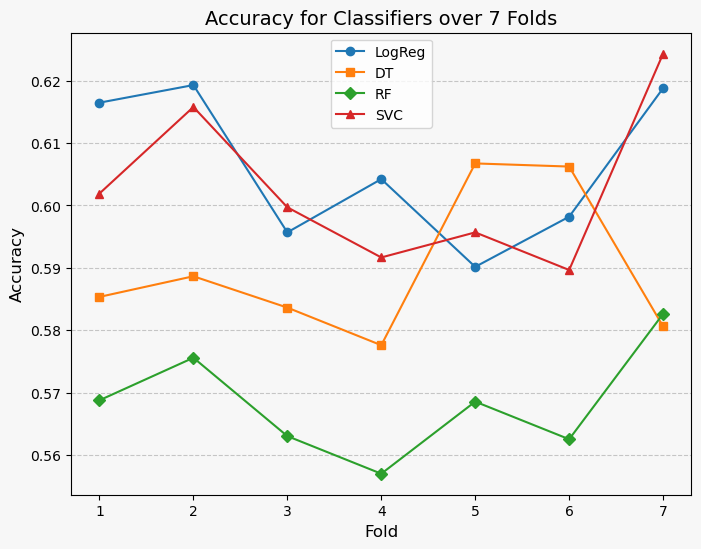

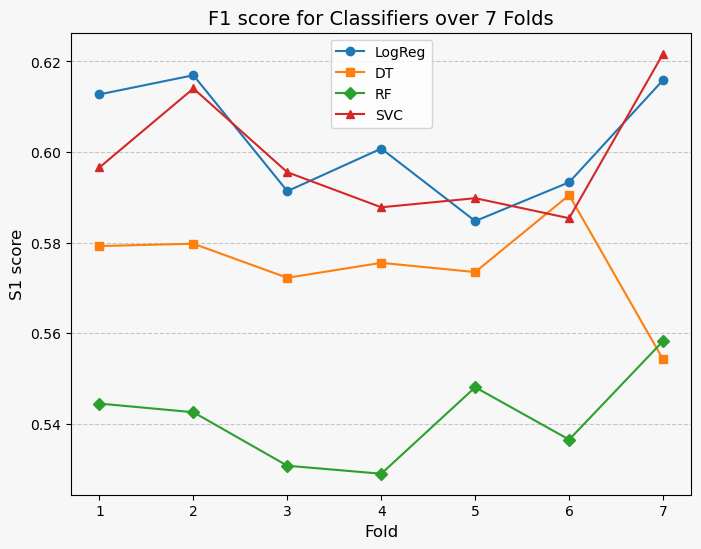

In [ ]:
plot_accuracy(results_dic)
plot_f1(results_dic)

## Step 7: Fusing variables 3 and 4

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import joblib
import scipy.sparse as sp
import pickle

df = pd.read_excel('classifier_data.xlsx')
df = df.dropna(subset=['tokenized_headline'])
df.head()

df = df.replace({'gender': {4: 3}})


# Reduce number of masculine tagged data
masc = df.query('gender == 2').sample(3088)
fem = df.query('gender == 1').sample(3088)
other = df.query('gender == 3').sample(3088)

df = pd.concat([masc, fem, other])

# Encode the categorical variable
le = LabelEncoder()
df['proper_name'] = le.fit_transform(df['proper_name'])

# Extract features using TF-IDF
with open("tfidf_vectorizer.pkl", "rb") as file:
    tfidf = pickle.load(file)
tfidf_features = tfidf.transform(df['tokenized_headline'])
tfidf_features = tfidf_features.toarray()

model_path = "sportword2vec.model"
w2v_model = Word2Vec.load(model_path)
sentences = [sentence.split() for sentence in df['tokenized_headline']]

embeddings = []
for sentence in sentences:
    sentence_embedding = []
    for word in sentence:
        if word in w2v_model.wv:
            sentence_embedding.append(w2v_model.wv[word])
    if sentence_embedding:
        sentence_embedding = np.mean(sentence_embedding, axis=0)
        embeddings.append(sentence_embedding)
    else:
        # Handle the case when no word in the sentence is present in the Word2Vec model's vocabulary
        embeddings.append(np.zeros(w2v_model.vector_size))
w2v_features = np.array(embeddings)


# Combine the features and the categorical variable
tfidf_sparse = sp.csr_matrix(tfidf_features)
w2v_sparse = sp.csr_matrix(w2v_features)
proper_name_sparse = sp.csr_matrix(np.array(df['proper_name']).reshape(-1, 1))

X = sp.hstack([tfidf_sparse,w2v_sparse,proper_name_sparse], format='csr')
y = df['gender']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Define the parameter grids for each model
logreg_param_grid = {'C': [0.01, 0.1, 1, 5]}
dt_param_grid = {'max_depth': [None, 5, 10]}
rf_param_grid = {'n_estimators': [100, 200, 300],
                    'max_depth': [40,50,60,None]}
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Create a list of models and their corresponding parameter grids
models = [
    (LogisticRegression(max_iter= 1000, multi_class='multinomial', solver='lbfgs'), logreg_param_grid),
    (DecisionTreeClassifier(), dt_param_grid),
    (RandomForestClassifier(), rf_param_grid),
    (SVC(), svm_param_grid)
]

best_model = None
best_score = 0.0

n_fold = 7

# Results dictionary
results_dic = {'Model':['LogReg','DT','RF','SVC'],'Accuracy':[],'F1':[],'Std Accuracy':[],'Std F1':[]}

# Perform GridSearchCV for each model
for model, param_grid in models:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_fold)
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and best score for each model
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best score for {model.__class__.__name__}: {grid_search.best_score_}\n")

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    test_predictions = best_model.predict(X_test)
    test_accuracy = best_model.score(X_test, y_test)
    test_f1 = f1_score(y_test, test_predictions, average='weighted')
    print(f"Test accuracy for {model.__class__.__name__}: {test_accuracy}")
    print(f"Test F1 score for {model.__class__.__name__}: {test_f1}")

    # Compute cross-validation scores
    cv_scores_accuracy = cross_val_score(grid_search.best_estimator_, X, y, cv=n_fold)
    cv_scores_f1 = cross_val_score(grid_search.best_estimator_, X, y, cv=n_fold, scoring='f1_weighted')
    print(f"Cross-validation scores (Accuracy) for {model.__class__.__name__}: {cv_scores_accuracy}")
    print(f"Cross-validation scores (F1) for {model.__class__.__name__}: {cv_scores_f1}")
    print(f"Mean cross-validation accuracy score for {model.__class__.__name__}: {np.mean(cv_scores_accuracy)}")
    print(f"Mean cross-validation F1 score for {model.__class__.__name__}: {np.mean(cv_scores_f1)}")
    print(f"Standard deviation of cross-validation accuracy scores for {model.__class__.__name__}: {np.std(cv_scores_accuracy)}")
    print(f"Standard deviation of cross-validation F1 scores for {model.__class__.__name__}: {np.std(cv_scores_f1)}\n")
    
    # Compute and print the test confusion matrix
    confusion_mat = confusion_matrix(y_test, test_predictions)
    print(f"Test Confusion Matrix for {model.__class__.__name__}:\n{confusion_mat}\n")
    
    # Save the best model based on the best score
    if grid_search.best_score_ > best_score:
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
    
    results_dic['Accuracy'].append(cv_scores_accuracy)
    results_dic['F1'].append(cv_scores_f1)
    results_dic['Std Accuracy'].append(np.std(cv_scores_accuracy))
    results_dic['Std F1'].append(np.std(cv_scores_f1))

# Save the best model to a file
if best_model is not None:
    joblib.dump(best_model, 'best_model_3class.pkl')
    print("Best model saved successfully.")

Best parameters for LogisticRegression: {'C': 1}
Best score for LogisticRegression: 0.633249410872485

Test accuracy for LogisticRegression: 0.6265515380464112
Test F1 score for LogisticRegression: 0.6239586073324116
Cross-validation scores (Accuracy) for LogisticRegression: [0.62839879 0.63897281 0.65181269 0.63340892 0.64399093 0.65306122
 0.64021164]
Cross-validation scores (F1) for LogisticRegression: [0.62587409 0.63523024 0.64862577 0.63062523 0.64298487 0.64712471
 0.63889173]
Mean cross-validation accuracy score for LogisticRegression: 0.6414081433657239
Mean cross-validation F1 score for LogisticRegression: 0.638479518828315
Standard deviation of cross-validation accuracy scores for LogisticRegression: 0.008377801829937685
Standard deviation of cross-validation F1 scores for LogisticRegression: 0.00783124065533393

Test Confusion Matrix for LogisticRegression:
[[394  78 145]
 [ 43 458 117]
 [166 143 309]]

Best parameters for DecisionTreeClassifier: {'max_depth': 5}
Best score

In [ ]:
# Results dictionary
results_dic = {'Model':['LogReg','DT','RF','SVC'],
               'Accuracy':[[0.62839879,0.63897281,0.65181269,0.63340892,0.64399093,0.65306122,0.64021164],
                          [0.68957704,0.70392749,0.70619335,0.69916856,0.71655329,0.6984127,0.6840514],
                          [0.63217523,0.63746224,0.65634441,0.63416478,0.65154951,0.63038549,0.62131519],
                          [0.63746224,0.64652568,0.668429,0.64021164,0.64701436,0.65154951,0.62811791]],
               'F1':[[0.62587409,0.63523024,0.64862577,0.63062523,0.64298487,0.64712471,0.63889173],
                    [0.69164153,0.70453122,0.70675298,0.69987487,0.71705246,0.69815824,0.6847335],
                    [0.63052557,0.63623158,0.64186347,0.63170561,0.64642057,0.62920438,0.61824258],
                    [0.63596686,0.64557538,0.66630015,0.63949828,0.64711225,0.6485641,0.62608905]],
               'Std Accuracy':[0.008377801829937685,0.009952467431161932, 0.011366795231572746 ,0.01171260957126097],
               'Std F1':[0.00783124065533393, 0.009726124596398931, 0.008515911196998294, 0.011561758399452466]}

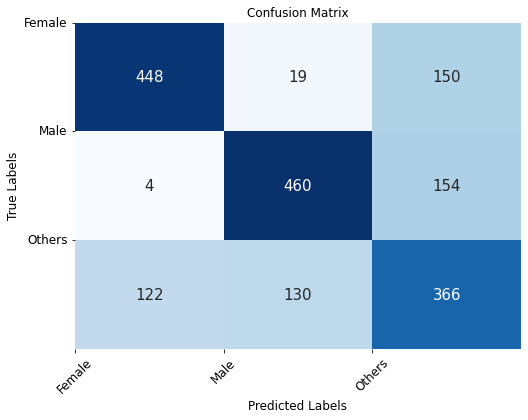

In [ ]:
confusion_matrix = [[448,  19, 150],
                     [  4, 460, 154],
                     [122, 130, 366]]


labels = ['Female', 'Male', 'Others']

plot_confusion_matrix(confusion_matrix, labels)

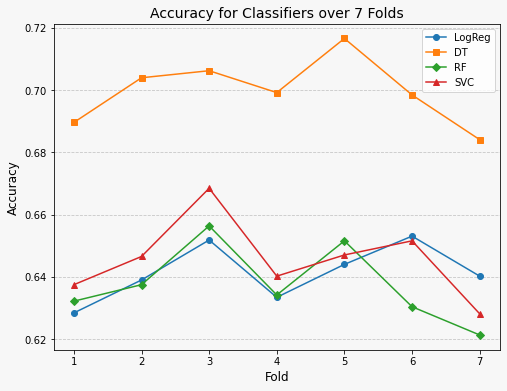

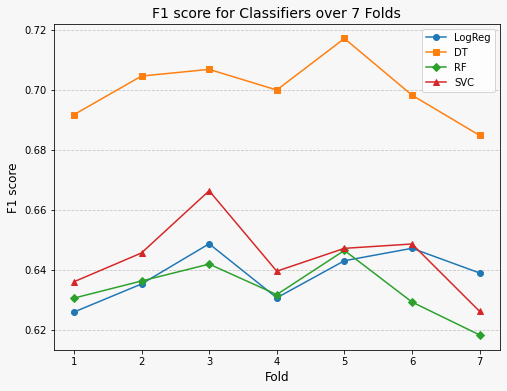

In [ ]:
plot_accuracy(results_dic)
plot_f1(results_dic)

## Step 8: Test set 2

In [ ]:
import pandas as pd
df = pd.read_excel('proyecto_navarra.xlsx')
df = df[['titular','nombre_propio','genero_de_los_q_aparecen']]
df = df.rename({'titular': 'headline', 'genero_de_los_q_aparecen': 'gender','nombre_propio':'proper_name'}, axis='columns')
df = df.replace({'gender': {4: 3}})

In [ ]:
len(df)

4590

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
import scipy.sparse as sp
import pickle

# Extract features using TF-IDF
filename = "tfidf_vectorizer.pkl"
with open(filename, "rb") as file:
    tfidf = pickle.load(file)
tfidf_features = tfidf.transform(df['headline'])
tfidf_features = tfidf_features.toarray()

model_path = "sportword2vec.model"
w2v_model = Word2Vec.load(model_path)
sentences = [sentence.split() for sentence in df['headline']]


embeddings = []
for sentence in sentences:
    sentence_embedding = []
    for word in sentence:
        if word in w2v_model.wv:
            sentence_embedding.append(w2v_model.wv[word])
    if sentence_embedding:
        sentence_embedding = np.mean(sentence_embedding, axis=0)
        embeddings.append(sentence_embedding)
    else:
        embeddings.append(np.zeros(w2v_model.vector_size))
w2v_features = np.array(embeddings)


# Combine the features and the categorical variable
tfidf_sparse = sp.csr_matrix(tfidf_features)
w2v_sparse = sp.csr_matrix(w2v_features)
proper_name_sparse = sp.csr_matrix(np.array(df['proper_name']).reshape(-1, 1))

X = sp.hstack([tfidf_sparse,w2v_sparse,proper_name_sparse], format='csr')
X.shape[1]

267927

In [ ]:
import joblib
# Specify the path to the saved SVM model file
model_file_path = 'best_model_3class.pkl'

# Load the SVM model
model = joblib.load(model_file_path)

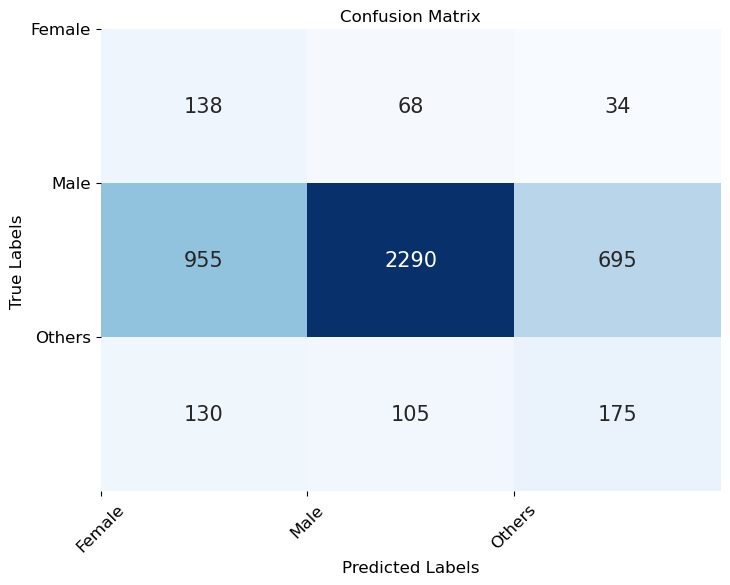

Accuracy:  0.5671023965141612
F1 score:  0.6476528978970457


In [ ]:
from sklearn.metrics import confusion_matrix
# Make predictions on the new data
new_predictions = model.predict(X)

# Calculate metrics
labels = ['Female', 'Male', 'Others']
confusion_mat = confusion_matrix(df['gender'], new_predictions)
plot_confusion_matrix(confusion_mat, labels)
print('Accuracy: ',accuracy_score(df['gender'], new_predictions))
print('F1 score: ',f1_score(df['gender'], new_predictions, average='weighted'))

## Step 9: Prediction

In [ ]:
import pandas as pd
df = pd.read_excel('preprocessed_data.xlsx')
random_sample = df.sample(n=10, random_state=42)
#random_sample

In [ ]:
random_sample['proper_name'] = None
random_sample['proper_name'][36459] = 0# --> proper_name 0
random_sample['proper_name'][51863] = 2# --> proper_name 2
random_sample['proper_name'][26820] = 2# --> proper_name 2
random_sample['proper_name'][40867] = 5# --> proper_name 5
random_sample['proper_name'][11153] = 2# --> proper_name 2
random_sample['proper_name'][47253] = 1# --> proper_name 1
random_sample['proper_name'][28367] = 4# --> proper_name 4
random_sample['proper_name'][8530] = 2# --> proper_name 2
random_sample['proper_name'][15277] = 4# --> proper_name 4
random_sample['proper_name'][28012] = 2# --> proper_name 2

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

# Encode the categorical variable
le = LabelEncoder()
random_sample['proper_name'] = le.fit_transform(random_sample['proper_name'])

# Extract features using TF-IDF
# Load the saved TF-IDF model
filename = "tfidf_vectorizer.pkl"
with open(filename, "rb") as file:
    tfidf = pickle.load(file)
tfidf_features = tfidf.transform(random_sample['tokenized_data'])
tfidf_features = tfidf_features.toarray()

model_path = "sportword2vec.model"
w2v_model = Word2Vec.load(model_path)
sentences = [sentence.split() for sentence in random_sample['tokenized_data']]


embeddings = []
for sentence in sentences:
    sentence_embedding = []
    for word in sentence:
        if word in w2v_model.wv:
            sentence_embedding.append(w2v_model.wv[word])
    if sentence_embedding:
        sentence_embedding = np.mean(sentence_embedding, axis=0)
        embeddings.append(sentence_embedding)
    else:
        # Handle the case when no word in the sentence is present in the Word2Vec model's vocabulary
        embeddings.append(np.zeros(w2v_model.vector_size))
w2v_features = np.array(embeddings)


# Combine the features and the categorical variable
tfidf_sparse = sp.csr_matrix(tfidf_features)
w2v_sparse = sp.csr_matrix(w2v_features)
proper_name_sparse = sp.csr_matrix(np.array(random_sample['proper_name']).reshape(-1, 1))

X = sp.hstack([tfidf_sparse,w2v_sparse,proper_name_sparse], format='csr')
#X = np.concatenate([tfidf_features, w2v_features], axis=1)
X.shape[1]

267927

In [ ]:
import joblib
# Specify the path to the saved SVM model file
model_file_path = 'best_model_3class.pkl'

# Load the SVM model
model = joblib.load(model_file_path)

# Make predictions on the new data
new_predictions = model.predict(X)

# Print the predictions
counter = 0
for index, row in random_sample.iterrows():
    pred = new_predictions[counter]
    if pred == 1:
        print('Headline: ',row['headline'],'// Link: ',row['link'],'// PREDICTED GENDER: ','Female')
    elif pred == 2:
        print('Headline: ',row['headline'],'// Link: ',row['link'],'// PREDICTED GENDER: ','Male')
    elif pred == 3:
        print('Headline: ',row['headline'],'// Link: ',row['link'],'// PREDICTED GENDER: ','Neutral')
    else:
        print('Headline: ',row['headline'],'// Link: ',row['link'],'// PREDICTED GENDER: ','Mixed')
    print('\n')
    counter += 1

Headline:  COD Warzone y Vangurad temporada 4; a qué hora comienza hoy y todo lo que sabemos // Link:  https://www.marca.com/videojuegos/2022/06/22/62b3293346163ff5618b45e9.html // PREDICTED GENDER:  Neutral


Headline:  Guede seguirá pese a los cánticos de La Rosaleda // Link:  https://www.marca.com/futbol/malaga/2022/09/05/6316012c22601d582a8b456c.html // PREDICTED GENDER:  Male


Headline:  Nadal - Isner: horario y dónde ver por TV y online hoy el partido del Masters de Roma // Link:  https://www.marca.com/tenis/masters-1000-roma/2022/05/11/627b71c422601d587a8b45b1.html // PREDICTED GENDER:  Male


Headline:  La presunta petición de Marta López a 'Supervivientes' para favorecer a Kiko Matamoros // Link:  https://www.marca.com/tiramillas/television/2022/07/13/62ce8330e2704ef5348b45b9.html // PREDICTED GENDER:  Male


Headline:  Simeone se lleva a Sevilla una lista de 17 jugadores... ¡y sólo cuatro defensas! // Link:  https://www.marca.com/futbol/atletico/2022/03/05/62238be5268e3e4103